首先我们引入必要的库：

In [2]:
from __future__ import print_function
import paddle
import paddle.fluid as fluid
import numpy
import math
import sys
import six

接下来我们定义了用于训练的数据提供器。提供器每次读入一个大小为BATCH_SIZE的数据批次。如果用户希望加一些随机性，它可以同时定义一个批次大小和一个缓存大小。这样的话，每次数据提供器会从缓存中随机读取批次大小那么多的数据。

In [2]:
BATCH_SIZE = 20

train_reader = fluid.io.batch(
    fluid.io.shuffle(
        paddle.dataset.uci_housing.train(), buf_size=500),
        batch_size=BATCH_SIZE)

test_reader = fluid.io.batch(
    fluid.io.shuffle(
        paddle.dataset.uci_housing.test(), buf_size=500),
        batch_size=BATCH_SIZE)

Cache file C:\Users\Dell/.cache/paddle/dataset\uci_housing\housing.data not found, downloading http://paddlemodels.bj.bcebos.com/uci_housing/housing.data 
Begin to download
............
Download finished


如果想直接从txt文件中读取数据的话，可以参考以下方式(需要自行准备txt文件)。

In [4]:
filename = 'housing.txt'
BATCH_SIZE = 20


feature_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
    'PTRATIO', 'B', 'LSTAT', 'convert'
]
feature_num = len(feature_names)
data = numpy.fromfile(filename, sep=' ') # 从文件中读取原始数据
data = data.reshape(data.shape[0] // feature_num, feature_num)
maximums, minimums, avgs = data.max(axis=0), data.min(axis=0), data.sum(axis=0)/data.shape[0]

for i in six.moves.range(feature_num-1):
    data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i]) # six.moves可以兼容python2和python3

ratio = 0.8 # 训练集和验证集的划分比例
offset = int(data.shape[0]*ratio)
train_data = data[:offset]
test_data = data[offset:]

def reader_creator(train_data):  
    def reader():  
        for d in train_data:  
            yield d[:-1], d[-1:]  
    return reader

train_reader = fluid.io.batch(
    fluid.io.shuffle(
        reader_creator(train_data), buf_size=500),
        batch_size=BATCH_SIZE)

test_reader = fluid.io.batch(
    fluid.io.shuffle(
        reader_creator(test_data), buf_size=500),
        batch_size=BATCH_SIZE)

配置训练程序

训练程序的目的是定义一个训练模型的网络结构。对于线性回归来讲，它就是一个从输入到输出的简单的全连接层。更加复杂的结果，比如卷积神经网络，递归神经网络等会在随后的章节中介绍。训练程序必须返回平均损失作为第一个返回值，因为它会被后面反向传播算法所用到。

In [5]:
x = fluid.data(name='x', shape=[None, 13], dtype='float32') # 定义输入的形状和数据类型
y = fluid.data(name='y', shape=[None, 1], dtype='float32') # 定义输出的形状和数据类型
y_predict = fluid.layers.fc(input=x, size=1, act=None) # 连接输入和输出的全连接层

main_program = fluid.default_main_program() # 获取默认/全局主函数
startup_program = fluid.default_startup_program() # 获取默认/全局启动程序

cost = fluid.layers.square_error_cost(input=y_predict, label=y) # 利用标签数据和输出的预测数据估计方差
avg_loss = fluid.layers.mean(cost) # 对方差求均值，得到平均损失

Optimizer Function 配置

在下面的 SGD optimizer，learning_rate 是学习率，与网络的训练收敛速度有关系。

In [7]:
#克隆main_program得到test_program
#有些operator在训练和测试之间的操作是不同的，例如batch_norm，使用参数for_test来区分该程序是用来训练还是用来测试
#该api不会删除任何操作符,请在backward和optimization之前使用
test_program = main_program.clone(for_test=True)

sgd_optimizer = fluid.optimizer.SGD(learning_rate=0.001)
_ = sgd_optimizer.minimize(avg_loss)

定义运算场所

我们可以定义运算是发生在CPU还是GPU

In [9]:
use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace() # 指明executor的执行场所

###executor可以接受传入的program，并根据feed map(输入映射表)和fetch list(结果获取表)向program中添加数据输入算子和结果获取算子。使用close()关闭该executor，调用run(...)执行program。
exe = fluid.Executor(place)

创建训练过程

训练需要有一个训练程序和一些必要参数，并构建了一个获取训练过程中测试误差的函数。必要参数有executor,program,reader,feeder,fetch_list，executor表示之前创建的执行器，program表示执行器所执行的program，是之前创建的program，如果该项参数没有给定的话则默认使用default_main_program，reader表示读取到的数据，feeder表示前向输入的变量，fetch_list表示用户想得到的变量或者命名的结果。

In [10]:
num_epochs = 100

def train_test(executor, program, reader, feeder, fetch_list):
    accumulated = 1 * [0]
    count = 0
    for data_test in reader():
        outs = executor.run(program=program,
                            feed=feeder.feed(data_test),
                            fetch_list=fetch_list)
        accumulated = [x_c[0] + x_c[1][0] for x_c in zip(accumulated, outs)] # 累加测试过程中的损失值
        count += 1 # 累加测试集中的样本数量
    return [x_d / count for x_d in accumulated] # 计算平均损失

训练主循环

给出需要存储的目录名，并初始化一个执行器。

In [11]:
%matplotlib inline
params_dirname = "fit_a_line.inference.model"
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])
exe.run(startup_program)
train_prompt = "train cost"
test_prompt = "test cost"
from paddle.utils.plot import Ploter
plot_prompt = Ploter(train_prbompt, test_prompt)
step = 0

exe_test = fluid.Executor(place)

paddlepaddle提供了reader机制来读取训练数据。reader会一次提供多列数据，因此我们需要一个python的列表来定义读取顺序。我们构建一个循环来进行训练，直到训练结果足够好或者循环次数足够多。 如果训练迭代次数满足参数保存的迭代次数，可以把训练参数保存到params_dirname。 设置训练主循环

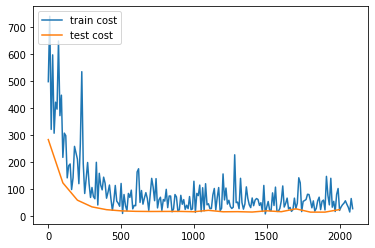

train cost, Step 2090, Cost 26.208342


<Figure size 432x288 with 0 Axes>

In [12]:
for pass_id in range(num_epochs):
    for data_train in train_reader():
        avg_loss_value, = exe.run(main_program,
                                  feed=feeder.feed(data_train),
                                  fetch_list=[avg_loss])
        if step % 10 == 0: # 每10个批次记录并输出一下训练损失
            plot_prompt.append(train_prompt, step, avg_loss_value[0])
            plot_prompt.plot()
            print("%s, Step %d, Cost %f" %
	                  (train_prompt, step, avg_loss_value[0]))
        if step % 100 == 0:  # 每100批次记录并输出一下测试损失
            test_metics = train_test(executor=exe_test,
                                     program=test_program,
                                     reader=test_reader,
                                     fetch_list=[avg_loss.name],
                                     feeder=feeder)
            plot_prompt.append(test_prompt, step, test_metics[0])
            plot_prompt.plot()
            print("%s, Step %d, Cost %f" %
	                  (test_prompt, step, test_metics[0]))
            if test_metics[0] < 10.0: # 如果准确率达到要求，则停止训练
                break

        step += 1

        if math.isnan(float(avg_loss_value[0])):
            sys.exit("got NaN loss, training failed.")

        #保存训练参数到之前给定的路径中
        if params_dirname is not None:
            fluid.io.save_inference_model(params_dirname, ['x'], [y_predict], exe)

Amazing!!!!!动态画学习效果图

# 预测

需要构建一个使用训练好的参数来进行预测的程序，训练好的参数位置在params_dirname。

准备预测环境

类似于训练过程，预测器需要一个预测程序来做预测。我们可以稍加修改我们的训练程序来把预测值包含进来。

In [13]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()

预测

保存图片

In [14]:
def save_result(points1, points2):
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    x1 = [idx for idx in range(len(points1))]
    y1 = points1
    y2 = points2
    l1 = plt.plot(x1, y1, 'r--', label='predictions')
    l2 = plt.plot(x1, y2, 'g--', label='GT')
    plt.plot(x1, y1, 'ro-', x1, y2, 'g+-')
    plt.title('predictions VS GT')
    plt.legend()
    plt.savefig('./image/prediction_gt.png')

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

infer results: (House Price)
0: 13.14
1: 13.90
2: 12.87
3: 16.42
4: 14.04
5: 15.69
6: 14.71
7: 14.39
8: 9.68
9: 13.75

ground truth:
0: 8.50
1: 5.00
2: 11.90
3: 27.90
4: 17.20
5: 27.50
6: 15.00
7: 17.20
8: 17.90
9: 16.30


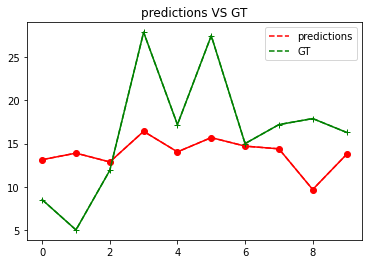

In [15]:
with fluid.scope_guard(inference_scope):
    [inference_program, feed_target_names,
     fetch_targets] = fluid.io.load_inference_model(params_dirname, infer_exe) # 载入预训练模型
    batch_size = 10

    infer_reader = fluid.io.batch(
        paddle.dataset.uci_housing.test(), batch_size=batch_size) # 准备测试集

    infer_data = next(infer_reader())
    infer_feat = numpy.array(
        [data[0] for data in infer_data]).astype("float32") # 提取测试集中的数据
    infer_label = numpy.array(
        [data[1] for data in infer_data]).astype("float32") # 提取测试集中的标签

    assert feed_target_names[0] == 'x'
    results = infer_exe.run(inference_program,
                            feed={feed_target_names[0]: numpy.array(infer_feat)},
                            fetch_list=fetch_targets) # 进行预测
    #打印预测结果和标签并可视化结果
    print("infer results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val)) # 打印预测结果

    print("\nground truth:")
    for idx, val in enumerate(infer_label):
        print("%d: %.2f" % (idx, val)) # 打印标签值

    save_result(results[0], infer_label) # 保存图片
